## Сумма элементов вектора. GPU VS CPU

Подключаем необходимые пакеты и задаем критерии работы CUDA

In [153]:
import time
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate
import pandas as pd

TPB = 16
ITER = 8

# TPB - Задаем количество нитей на блок,
# ITER - Количество итераций пересчета вычислений

Функция вычисления суммы вектора на GPU

In [154]:
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB
    if idx < vec.shape[0]:
      cuda.atomic.add(res, 0, vec[idx])

Функция компилирующая вычисление скорости сложения значений вектора на CPU и GPU

In [155]:
def calculation():
    rows = [] 
    vec_size_min = 1_000                                                            # Минимальная длина вектора в итерации
    vec_size_max = 1_000_000                                                        # Максимальная длина вектора в итерации
    vec_size_interval = 20_000                                                      # Шаг изменения длины вектора от min к max размеру
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER):
            vec = np.ones(vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            start = time.time() 
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            gpu_time_sum += time.time() - start
            res = d_res.copy_to_host()

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

        row = [vec_size,  cpu_time_sum / ITER, gpu_time_sum / ITER]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'cpu, ms', 'gpu, ms']))
    return rows

Получаем DataFrame с итоговыми данными по ускорению

In [ ]:
output_data = calculation()                                       # Получаем результаты выполнения функции вычисления скорости и записываем их в DataFrame

df = pd.DataFrame(output_data,columns =['vec_array', 'cpu_time_array', 'gpu_time_array'])
df = df[(df['gpu_time_array'] > 0) & (df['cpu_time_array'] > 0) ]
df['acceleration'] = df['cpu_time_array'] / df['gpu_time_array']  # Расчет ускорения GPU vs CPU

Строим графики

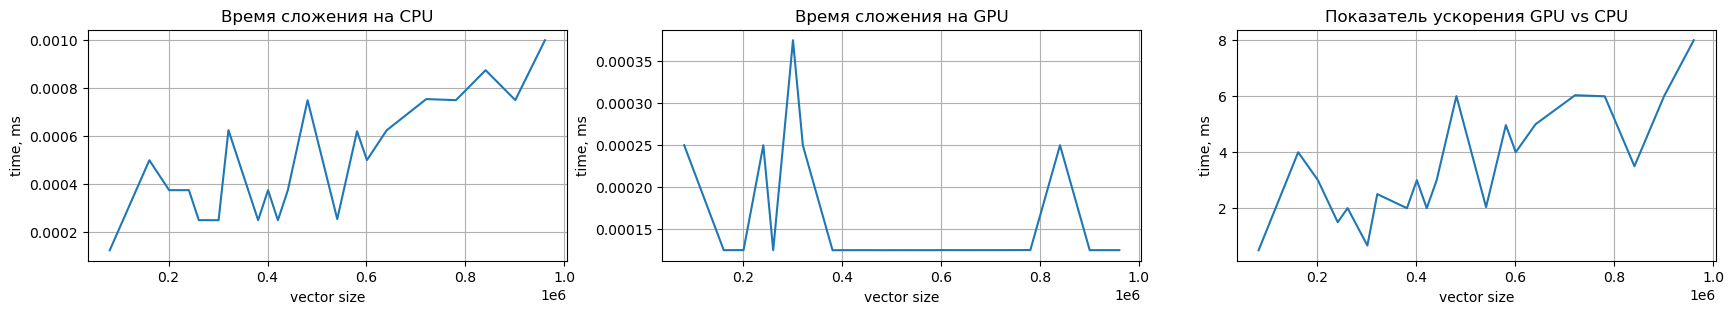

In [174]:
plt.figure(figsize=(21,3))
plt.subplot(1, 3, 1)
plt.title("Время сложения на CPU")
plt.plot(df['vec_array'], df['cpu_time_array'])
plt.xlabel("vector size")
plt.ylabel("time, ms")
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Время сложения на GPU")
plt.plot(df['vec_array'], df['gpu_time_array'])
plt.xlabel("vector size")
plt.ylabel("time, ms")
plt.grid()

plt.subplot(1, 3, 3)
plt.title("Показатель ускорения GPU vs CPU")
plt.plot(df['vec_array'], df['acceleration'])
plt.xlabel("vector size")
plt.ylabel("time, ms")
plt.grid()

Выводы:

1. Если длина вектора менее 100_000 то ускорение на GPU практически не наблюдается относительно CPU
2. Значительный прирост скорости в GPU получаем после 800_000 (сложение элементов вектора на GPU происходит быстрее более чем в 4 раза от значений на CPU)